In [2]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## **1. Import Necessary packages**

In [3]:
import numpy as np
import pandas as pd
from pandas import Grouper
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf

## **2. Read the Dataset**

In [4]:
#path_to_files='/gdrive/My Drive/CapstoneProject/Full_Dataset/'
path_to_results='/gdrive/My Drive/Capstone/Saved_Models/'

path_to_files='/gdrive/My Drive/Capstone/Full_Dataset/'

In [5]:
# Load the datasets
data = pd.read_csv(path_to_files + 'Full_Dataset.csv')

In [6]:
# Shape of dataset
print('Shape of Dataset : ',str(data.shape))

Shape of Dataset :  (560061, 4)


In [7]:
# Check datatypes
data.dtypes

Date                object
Time                object
Zone                object
Temperature (F)    float64
dtype: object

In [8]:
data.head()

,Date,Time,Zone,Temperature (F)
0,2019-11-04,16:50,EST,67.5
1,2019-11-04,16:51,EST,67.3
2,2019-11-04,16:52,EST,67.3
3,2019-11-04,16:53,EST,67.3
4,2019-11-04,16:54,EST,67.2


In [9]:
data.tail()

,Date,Time,Zone,Temperature (F)
560056,2020-01-27,22:34,EST,43.2
560057,2020-01-27,22:35,EST,43.0
560058,2020-01-27,22:36,EST,43.7
560059,2020-01-27,22:37,EST,43.2
560060,2020-01-27,22:38,EST,43.2


## **3. Find Missing (or) Null Values**  

In [10]:
data.isnull().sum()

Date               0
Time               0
Zone               0
Temperature (F)    0
dtype: int64

## **3. Drop columns not used in model Building**  

In [11]:
data.drop(['Date', 'Time', 'Zone'], axis = 1, inplace=True)

## **4. Model building using LSTM**

####  Create training and test datasets by Standardising the input

In [12]:
def scale_and_split_dataset(scaled):

  #70% examples will used for training (in the begining)
  train_size = int(len(scaled) * 0.70)

  #30% will be used for Test
  test_size = len(scaled) - train_size

  #print('train_size = {}, test_size = {}'.format(train_size, test_size))
  #Split the data
  train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
  #print('train: {}\ntest: {}'.format(len(train), len(test)))
  print("Train data shape is",train.shape)
  print("Test data shape is",test.shape)

  return train, test

####  Create X and y based on window_size

In [13]:
#window - how long the sequence will be
def create_dataset(dataset, window=1):    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-window):       
        a = dataset[i:(i+window), 0]        
        dataX.append(a)
        dataY.append(dataset[i + window, 0])
    
    return np.array(dataX), np.array(dataY)

#### Make data 3 dimensional for LSTM input

In [14]:
def make_3dim(X_train, X_test):
  #make it 3 Dimensional Data - needed for LSTM
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  print("Shape of X_train and X_test after reshaping into (length of input, no of time steps, no of features)")
  print(X_train.shape)
  print(X_test.shape)

  return X_train, X_test

#### Build and compile LSTM model using NADAM optimizer

In [15]:
def build_and_compile_model(units=256, dropout=0.15, window_size=1):
  
  tf.keras.backend.clear_session()
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(units=units, activation='relu', input_shape=(window_size, 1)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(1))
  model.compile(optimizer='Nadam', loss='mse')

  return model

### Call back to save best model with least loss

In [16]:
# Add model checkpoint to save the best model weights.The best model is one with least validation loss
def call_back(window_size):
  if window_size == 60:
    LSTMcheckpoint_path = "/content/drive/My Drive/Capstone/Saved_Models/lstm_full_dataset_60min.ckpt"
  elif window_size == 120:
    LSTMcheckpoint_path = "/content/drive/My Drive/Capstone/Saved_Models/lstm_full_dataset_120min.ckpt"
  elif window_size == 180:
    LSTMcheckpoint_path = "/content/drive/My Drive/Capstone/Saved_Models/lstm_full_dataset_180min.ckpt"
  else:
    LSTMcheckpoint_path = "/content/drive/My Drive/Capstone/Saved_Models/lstm_full_dataset_600min.ckpt"
  
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=LSTMcheckpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode = 'min',
                                                 save_best_only=True,
                                                 verbose=1)

  return LSTMcheckpoint_path, cp_callback

#### Find Predictions using train and test data

In [17]:
def make_predictions(model, X_train, X_test):
  return model.predict(X_train), model.predict(X_test)

#### Find metrics - mse, rmse, mae, r2_score

In [18]:
def find_metrics(trainPredict, testPredict, y_train, y_test, window_size):
  
  train_mse = mean_squared_error(y_train, trainPredict)
  train_rmse = np.sqrt(train_mse)
  train_mae = mean_absolute_error(y_train, trainPredict)
  train_r2 = r2_score(y_train, trainPredict)

  test_mse = mean_squared_error(y_test, testPredict)
  test_rmse = np.sqrt(test_mse)
  test_mae = mean_absolute_error(y_test, testPredict)
  test_r2 = r2_score(y_test, testPredict)

  print("Metrics for train and test datasets:\n")
  print("train_mse = ", train_mse)
  print("test_mse = ", test_mse)

  print("\ntrain_rmse = ", train_rmse)
  print("test_rmse = ", test_rmse)

  print("\ntrain_mae = ", train_mae)
  print("test_mae = ", test_mae)

  print("\ntrain_r2 = ", train_r2)
  print("test_r2 = ", test_r2)

  dict_metrics = {
                    'Window Size' : [window_size],
                    'Model Name' : ['LSTM'], 
                    'Train MAE' : [round(train_mae, 4)],
                    'Test MAE' : [round(test_mae, 4)],
                    'Train MSE' : [round(train_mse, 4)],  
                    'Test MSE' : [round(test_mse, 4)],                
                    'Train RMSE' : [round(train_rmse, 4)],
                    'Test RMSE' : [round(test_rmse, 4)],
                    'Train R2 Score' : [round(train_r2, 4)],                    
                    'Test R2 Score' : [round(test_r2, 4)]
                  }
  metrics_df = pd.DataFrame(dict_metrics)
  return metrics_df

#### Inverse transform the scaled data

In [19]:
def inverse_transform(trainPredict, testPredict, scaler):
  return scaler.inverse_transform(trainPredict), scaler.inverse_transform(testPredict)

#### Plot baseline, train and test predicted data

In [20]:
def plot_predictions(scaled, scaler, trainPredict_inverse, testPredict_inverse, window_size=1):

  trainPredict = trainPredict_inverse
  testPredict = testPredict_inverse

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(scaled)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict
  
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(scaled)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict

  # plot baseline, trainPredict and testPredict
  plt.figure(figsize=(10,5))
  labels = ['baseline', 'trainPredict', 'testPredict']

  #baseline plot
  plt.plot(scaler.inverse_transform(scaled), color='black')

  
  #Train Predicted Plot
  plt.plot(trainPredictPlot, color='deepskyblue')

  #Test Predicted Plot
  plt.plot(testPredictPlot, color='darkorange')
  
  plt.legend(labels)
  plt.show()

### Build LSTM Model using NADAM optimizer

In [22]:
#Normalize using StandarScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(data)

#Normalize using MinMax Scaler
minmax_scaler = MinMaxScaler()
minmax_scaled = minmax_scaler.fit_transform(data)

In [23]:
#initialize parameters
epochs = 5
batch_size = 64
units=256
dropout=0.15

### 600 Min Prediction

In [27]:
#initialize window_size
window_size = 600

#split the data into test and train
train, test = scale_and_split_dataset(scaled)

#Create Input and Output
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)
print('X_train shape is {}, y_train shape is {}'.format(X_train.shape, y_train.shape))
print('X_test shape is {}, y_test shape is {}'.format(X_test.shape, y_test.shape))

#make data 3 dimensional for LSTM
X_train, X_test = make_3dim(X_train, X_test)
print(X_train[0,0:3,0])
print(X_test[0,0:3,0])

#Build and compile the model
model_600min = build_and_compile_model(units=units, dropout=dropout, window_size=window_size)

#Add model checkpoint to save the best model weights.The best model is one with least validation loss
LSTMcheckpoint_path, cp_callback_600min = call_back(window_size)

#fit the model
history_model_600min = model_600min.fit(X_train, y_train, 
                                      validation_data=(X_test, y_test), 
                                      epochs=epochs, batch_size=batch_size, 
                                      callbacks=[cp_callback_600min])

Train data shape is (392042, 1)
Test data shape is (168019, 1)
X_train shape is (391442, 600), y_train shape is (391442,)
X_test shape is (167419, 600), y_test shape is (167419,)
Shape of X_train and X_test after reshaping into (length of input, no of time steps, no of features)
(391442, 600, 1)
(167419, 600, 1)
[4.35361534 4.32151148 4.32151148]
[-0.83115826 -0.91141792 -0.94352178]
Epoch 1/5
6117/6117 [==============================] - ETA: 0s - loss: 0.0424
Epoch 00001: val_loss improved from inf to 0.01152, saving model to /content/drive/My Drive/Capstone/Saved_Models/lstm_full_dataset_600min.ckpt
6117/6117 [==============================] - 4754s 777ms/step - loss: 0.0424 - val_loss: 0.0115
Epoch 2/5
6117/6117 [==============================] - ETA: 0s - loss: 0.0345
Epoch 00002: val_loss did not improve from 0.01152
6117/6117 [==============================] - 4780s 781ms/step - loss: 0.0345 - val_loss: 0.0133
Epoch 3/5
6117/6117 [==============================] - ETA: 0s - loss:

In [28]:
LSTMcheckpoint_path

'/content/drive/My Drive/Capstone/Saved_Models/lstm_full_dataset_600min.ckpt'

Metrics for train and test datasets:

train_mse =  0.013269594933313698
test_mse =  0.008652108319141079

train_rmse =  0.11519372783842746
test_rmse =  0.09301670989204616

train_mae =  0.05382964741690575
test_mae =  0.05083193810379347

train_r2 =  0.9885389654654602
test_r2 =  0.9855212079423066


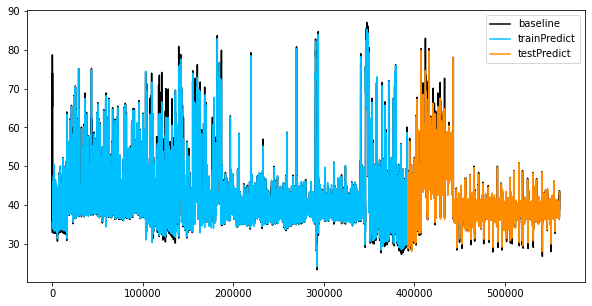

In [29]:
#load the saved weights for best model with least accuracy
model_600min.load_weights(LSTMcheckpoint_path)
#cp "/gdrive/My Drive/Capstone/Saved_Models/lstm_full_dataset_600min.ckpt" 

#make predictions
trainPredict, testPredict = make_predictions(model_600min, X_train, X_test)

#find_metrics
window_600_df = find_metrics(trainPredict, testPredict, y_train, y_test, window_size)

#inverse scaled data
trainPredict_inverse, testPredict_inverse = inverse_transform(trainPredict, testPredict, scaler)

#plot predictions with respect to baseline
plot_predictions(scaled, scaler, trainPredict_inverse, testPredict_inverse, window_size=window_size)

#save the results
window_600_df.to_excel(path_to_results + 'LSTM_Full_Dataset_600min_Results.xlsx', index=False)

## Outliers in Full Data

In [30]:
data.head()

,Temperature (F)
0,67.5
1,67.3
2,67.3
3,67.3
4,67.2


In [34]:
import sys
sys.path.append('/gdrive/My Drive/Capstone/Walkin_Temp/1min_Average_Datasets') #change the path where CommonMethods module is placed in your PC

import CommonMethods as common

In [31]:
data.rename(columns = {'Temperature (F)' : 'Temperature'}, inplace = True)

In [35]:
lstConditions = common.getOutlierBoundaryConditions(data)
outlier_df = data.loc[lstConditions[0] | lstConditions[1]]

40.6
37.6


In [36]:
outlier_df.shape

(74467, 1)

In [37]:
outlier_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,74467.0,51.477724,11.053637,23.4,46.7,49.1,55.5,87.1
